### Projeto Final | Machine Learning
##### Lucas Fontenla - 9° Semestre - Eng. Mecatrônica

O projeto consiste em um modelo de regressão para previsão de Dividendos Trimestrais de Fundos de Investimento Imobiliário.

Os dados, por sua natureza, contém variáveis multicategóricas e numéricas em um grande número de colunas. Propõe-se um modelo de redução de dimensionalidade para um dataset do tipo, que, consequentemtne, melhore o desempenho do modelo de regressão.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import utils as u
from timeit import default_timer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# list importances and return the list of features
def get_importances(importances, features_names, max_features=None, display=True, round_value=5):
    # adapted from: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, round_value)) for feature, importance in zip(features_names, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)[:max_features]
    features_selected = [ix[0] for ix in feature_importances] 

    if display:
        # Print out the feature and importances 
        [print(f'{ix+1:2}. Variable: {pair[0]:30} Importance: {pair[1]}') for ix, pair in enumerate(feature_importances)];
        
    return features_selected

In [3]:
# raw file
FILE_PATH = os.path.abspath(os.curdir+"\\..\\data-processing\\data\\funds.pkl")
funds_df_raw = pd.read_pickle(FILE_PATH)

In [4]:
from sklearn.pipeline import Pipeline

cat_columns = ['Administrador', 'Tipo de Gestão', 'Público Alvo', 'Mandato', 'Segmento', 'Prazo de Duração']
text_columns = ['Descrição', 'Taxa de Administração']

# data processing pipeline with custom created classes
pipeline = Pipeline([   
    ('clean-description-headers', u.CleanHeaders(col=3)),
    ('clean-description-punct', u.CleanPunct(col=3)),
    ('input-const-admin-tax', u.FillColumn(col=11, method='const', const='0,2% a.a.')),
    ('clean-admin-tax-headers', u.CleanHeaders(col=11)),
    ('clean-admin-tax-punct', u.CleanPunct(col=11)),
    ('input-foundation-date', u.InputDate(col=4, ref_col=16)),
    ('input-mean-daily-liquidity', u.FillColumn(col=14, method='median')),
    ('process-dividends', u.ProcessDividends(col=17)),
    ('process-prices', u.ProcessPrices(col=16)),
    ('process-equity', u.ProcessEquity(col=19)),
    ('standard-scaler', u.StdScaler(exclude_col=['Div. Acum. Últ. Trimestre', 'Data de Constituição do Fundo'])),
    ('process-vacancy', u.ProcessVacancy(col=20)),
    ('process-assets', u.ProcessAssets(col=13)),
    ('drop-columns', u.DropColumns(cols=["Taxa de Performance", "Ativos Atuais", "Cotações Históricas",
                                         "Dividendos Históricos", "Dividend Yield Histórico", "Nome",
                                         "Valor Patrimonial Histórico", "Vacância Histórica", 'Descrição',
                                         'Taxa de Administração', "Div. M-0", "Div. M-1", "Div. M-2", 
                                         "Preços Média M-0", "Preços Média M-1", 
                                         "Preços Média M-2", "Val. Patr. M-0", "Val. Patr. M-1", 
                                         "Val. Patr. M-2", "Vacância M-0", "Vacância M-1", 
                                         "Vacância M-2", "Ticker", "Data de Constituição do Fundo"])),
    ('drop-rows', u.DropRows(rows='all')),
    ('cat-encoding', u.OneHotEncoder2(col=cat_columns)),
    ('convert-available2float', u.Convert2Float())
]) 

In [5]:
# transformation of the raw data
funds_df = pipeline.fit_transform(funds_df_raw)

C:\Users\lucas\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Running Std. Scaler
Unable to std. scale 'Ticker'
Unable to std. scale 'Nome'
Unable to std. scale 'Administrador'
Unable to std. scale 'Descrição'
Skipping Data de Constituição do Fundo
Unable to std. scale 'Tipo de Gestão'
Unable to std. scale 'Público Alvo'
Unable to std. scale 'Mandato'
Unable to std. scale 'Segmento'
Unable to std. scale 'Prazo de Duração'
Unable to std. scale 'Taxa de Administração'
Unable to std. scale 'Taxa de Performance'
Unable to std. scale 'Ativos Atuais'
Unable to std. scale 'Cotações Históricas'
Unable to std. scale 'Dividendos Históricos'
Unable to std. scale 'Dividend Yield Histórico'
Unable to std. scale 'Valor Patrimonial Histórico'
Unable to std. scale 'Vacância Histórica'
Skipping Div. Acum. Últ. Trimestre


C:\Users\lucas\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\lucas\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Running Convert2Float


Após o processamento dos dados com o pipeline criado, verifica-se que há 140 colunas para somente 121 linhas. Nas linhas abaixo, pode-se observar um recorte do dataset e todas as suas 140 colunas adicionadas.

In [6]:
funds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Columns: 140 entries, Cotas Emitidas to Indeterminado
dtypes: float64(140)
memory usage: 132.5 KB


In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 5)
funds_df.head(n=3)

,Cotas Emitidas,Liquidez Diária,Patrimônio Líquido,Div. M-3,Div. M-4,Div. M-5,Div. M-6,Div. M-7,Div. M-8,Div. M-9,Div. M-10,Div. M-11,Div. Acum. Últ. Trimestre,Div. Média,Div. Min,Div. Max,Div. Desv. Pad. Rel.,Div. Assimetria,Div. Curtose,Preços Média M-3,Preços Média M-4,Preços Média M-5,Preços Média M-6,Preços Média M-7,Preços Média M-8,Preços Média M-9,Preços Média M-10,Preços Média M-11,Preços Média,Preços Min,Preços Max,Preços Desv. Pad. Rel.,Preços Assimetria,Preços Curtose,Preços Variação Total,Val. Patr. M-3,Val. Patr. M-4,Val. Patr. M-5,Val. Patr. M-6,Val. Patr. M-7,Val. Patr. M-8,Val. Patr. M-9,Val. Patr. M-10,Val. Patr. M-11,Val. Patr. Média,Val. Patr. Min,Val. Patr. Max,Val. Patr. Desv. Pad. Rel.,Val. Patr. Assimetria,Val. Patr. Curtose,Va. Patr. Variação Total,Vacância M-3,Vacância M-4,Vacância M-5,Vacância M-6,Vacância M-7,Vacância M-8,Vacância M-9,Vacância M-10,Vacância M-11,Vacância Média,Vacância Min,Vacância Max,Vacância Desv. Pad. Rel.,Vacância Assimetria,Vacância Curtose,Área dos Ativos AC,Área dos Ativos AL,Área dos Ativos AP,Área dos Ativos AM,Área dos Ativos BA,Área dos Ativos CE,Área dos Ativos DF,Área dos Ativos ES,Área dos Ativos GO,Área dos Ativos MA,Área dos Ativos MT,Área dos Ativos MS,Área dos Ativos MG,Área dos Ativos PA,Área dos Ativos PB,Área dos Ativos PR,Área dos Ativos PE,Área dos Ativos PI,Área dos Ativos RJ,Área dos Ativos RN,Área dos Ativos RS,Área dos Ativos RO,Área dos Ativos RR,Área dos Ativos SC,Área dos Ativos SP,Área dos Ativos SE,Área dos Ativos TO,BNYMELLON,BRB,BRL Trust Investimentos,BTG Pactual,Banco Fator,Bradesco,Brasil Plural,CM CAPITAL MARKETS,Caixa Economica Federal,CitiBanbk,Coinvalores,Credit Suisse Hedging-Griffo,Geração Futuro,Hedge Investments,Intrag DTVM,JPP Capital Gestão de Recursos Ltda,Oliveira Trust,Ourinvest,Planner,Rio Bravo,Safra Asset Management,Socopa,Unitas,Vortx,Votorantim Asset,XP Investimentos,Ativa,Passiva,Investidor Qualificado,Investidor Qualificado e Profissional,Investidores em Geral,Desenvolvimento para Renda,Desenvolvimento para Venda,Híbrido,Renda,Títulos e Valores Mobiliários,Hospital,Hotel,Híbrido,Lajes Corporativas,Logística,Outros,Residencial,Shoppings,Títulos e Val. Mob.,Determinado,Indeterminado
0,-0.264143,-0.130326,0.921727,-0.144090,-0.255129,-0.262867,-0.252962,-0.237117,-0.234113,-0.231847,-0.225807,-0.217162,0.49000,-0.430172,-0.376736,-0.275419,-0.027793,0.056355,-0.243625,-0.307979,-0.316181,-0.354133,-0.338829,-0.334165,-0.332466,-0.345516,-0.325687,-0.359992,-0.432328,-0.504499,-0.391723,0.701969,0.287953,-0.174320,-0.013201,-0.315057,-0.295514,-0.302407,-0.308138,-0.307965,-0.298974,-0.246026,-0.266270,-0.255655,-0.075766,-0.395168,-0.069865,0.291534,0.257567,-0.368174,2.142954,0.010,0.010,0.010,0.009,0.011,0.013,0.013,0.011,0.011,0.011583,0.009,0.014,0.149341,0.128655,-1.404736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69628.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.264426,-0.073225,-0.261867,-0.210746,-0.238206,-0.244250,-0.236651,-0.243887,-0.236234,-0.227819,-0.228859,-0.153668,1.76911,-0.345044,-0.376736,-0.278857,-0.429152,-1.556820,0.126233,-0.270989,-0.267813,-0.327803,-0.337433,-0.337208,-0.339510,-0.363618,-0.341632,-0.356112,-0.343837,-0.284424,-0.344520,-0.451665,0.897284,0.037895,-0.083029,-0.296438,-0.277112,-0.283110,-0.267199,-0.265754,-0.257018,-0.428945,-0.222590,-0.214427,-0.074684,-0.301304,-0.069808,-0.395280,-0.164892,-0.510814,0.038661,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000000,0.000,0.000,0.000000,0.000000,-3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8178.0,0.0,0.0,0.0,0.0,0.0,44462.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0

A descrição de um dataset do tipo, para variáveis categóricas, resulta em um interpretação não conclusiva, por média e correlação, por exemplo, não tem sentido no contexto de variáveis dummy.

In [8]:
funds_df.describe()

,Cotas Emitidas,Liquidez Diária,Patrimônio Líquido,Div. M-3,Div. M-4,Div. M-5,Div. M-6,Div. M-7,Div. M-8,Div. M-9,Div. M-10,Div. M-11,Div. Acum. Últ. Trimestre,Div. Média,Div. Min,Div. Max,Div. Desv. Pad. Rel.,Div. Assimetria,Div. Curtose,Preços Média M-3,Preços Média M-4,Preços Média M-5,Preços Média M-6,Preços Média M-7,Preços Média M-8,Preços Média M-9,Preços Média M-10,Preços Média M-11,Preços Média,Preços Min,Preços Max,Preços Desv. Pad. Rel.,Preços Assimetria,Preços Curtose,Preços Variação Total,Val. Patr. M-3,Val. Patr. M-4,Val. Patr. M-5,Val. Patr. M-6,Val. Patr. M-7,Val. Patr. M-8,Val. Patr. M-9,Val. Patr. M-10,Val. Patr. M-11,Val. Patr. Média,Val. Patr. Min,Val. Patr. Max,Val. Patr. Desv. Pad. Rel.,Val. Patr. Assimetria,Val. Patr. Curtose,Va. Patr. Variação Total,Vacância M-3,Vacância M-4,Vacância M-5,Vacância M-6,Vacância M-7,Vacância M-8,Vacância M-9,Vacância M-10,Vacância M-11,Vacância Média,Vacância Min,Vacância Max,Vacância Desv. Pad. Rel.,Vacância Assimetria,Vacância Curtose,Área dos Ativos AC,Área dos Ativos AL,Área dos Ativos AP,Área dos Ativos AM,Área dos Ativos BA,Área dos Ativos CE,Área dos Ativos DF,Área dos Ativos ES,Área dos Ativos GO,Área dos Ativos MA,Área dos Ativos MT,Área dos Ativos MS,Área dos Ativos MG,Área dos Ativos PA,Área dos Ativos PB,Área dos Ativos PR,Área dos Ativos PE,Área dos Ativos PI,Área dos Ativos RJ,Área dos Ativos RN,Área dos Ativos RS,Área dos Ativos RO,Área dos Ativos RR,Área dos Ativos SC,Área dos Ativos SP,Área dos Ativos SE,Área dos Ativos TO,BNYMELLON,BRB,BRL Trust Investimentos,BTG Pactual,Banco Fator,Bradesco,Brasil Plural,CM CAPITAL MARKETS,Caixa Economica Federal,CitiBanbk,Coinvalores,Credit Suisse Hedging-Griffo,Geração Futuro,Hedge Investments,Intrag DTVM,JPP Capital Gestão de Recursos Ltda,Oliveira Trust,Ourinvest,Planner,Rio Bravo,Safra Asset Management,Socopa,Unitas,Vortx,Votorantim Asset,XP Investimentos,Ativa,Passiva,Investidor Qualificado,Investidor Qualificado e Profissional,Investidores em Geral,Desenvolvimento para Renda,Desenvolvimento para Venda,Híbrido,Renda,Títulos e Valores Mobiliários,Hospital,Hotel,Híbrido,Lajes Corporativas,Logística,Outros,Residencial,Shoppings,Títulos e Val. Mob.,Determinado,Indeterminado
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.00000,121.000000,121.000000,121.000000,121.00000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.0,121.000000,121.0,121.000000,121.000000,121.000000,121.000000,121.00000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.0,121.000000,121.000000,121.00000,121.0,121.0,121.000000,121.000000,121.000000,121.0,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.00000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.00000,121.000000,121.00000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,-0.091742,-0.061874,0.176610,0.119163,0.129578,0.161603,0.124985,0.141574,0.139370,0.170042,0.169974,0.203436,4.954342,0.055217,-0.004481,0.080071,0.036618,0.106884,0.209311,0.054021,0.043340,0.001492,-0.027490,-0.022670,0.002642,-0.030591,-0.010179,-0.051466,-0.00

A distribuição dos dividendos acumulados no último trimestre se mostra essencialmente abaixo de R$20/tri. Sendo assim, optou-se por remover valores superiores à esse.

É importante ressaltar que, todas as variáveis que tinham algum dado presente nos 3 meses em que a coluna "Div. Acum. Últ. Trimestre" compreendia, foram removidos (e.g. "Div. M-1", "Preços Média M-2"...)

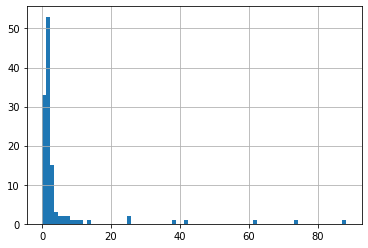

In [9]:
funds_df['Div. Acum. Últ. Trimestre'].hist(bins=75)

In [10]:
funds_df = funds_df[funds_df['Div. Acum. Últ. Trimestre'] < 20]

## Modelagem
### Separação dos dados

In [11]:
features = funds_df.drop(columns=["Div. Acum. Últ. Trimestre"])
labels = funds_df[["Div. Acum. Últ. Trimestre"]]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=RANDOM_SEED)

In [13]:
# obtaining only categorical variables
X_train_cat = X_train.iloc[:,93:]
X_train_num = X_train.iloc[:,:93]

X_test_cat = X_test.iloc[:,93:]
X_test_num = X_test.iloc[:,:93]

### Baseline

Estabelecendo um baseline para o problema: a média dos dividendos (em dividendos, sempre me refiro ao acumulado do últmo trimestre).

O modelo criado deverá minimamente superar essa estatística.

In [14]:
y_pred_mean = [np.mean(y_train).item()]*y_train.shape[0]
print(f'Média: { y_pred_mean[0] }')

Média: 2.2078498502897346


In [15]:
rmse_baseline = np.sqrt(mean_squared_error(y_train, y_pred_mean))
print(f'Baseline RMSE: { rmse_baseline }')

Baseline RMSE: 2.3056695999775165


## Variáveis categóricas

### 1. Random Forest

As variáveis categóricas são muitas. Redução de dismensionalidade por métodos "tradicionais", a base de variância, por exemplo, não servem para aplicações categóricas pois implicam em uma continuidade entre os pontos e suas respectivas distâncias euclidianas. Sendo assim, não fazem sentido.

A primeira abordagem utiliza o modelo `RandomForest()` para listar as importâncias das variáveis categóricas.

Para todos os estudos aqui realizados, foram considerados sempre as 10 melhores features.

In [16]:
target_n_features = 10

##### Random Forest Baseline

Um performance base do Random Forest é obtida usando os valores padrão da biblioteca.

In [17]:
# baseline
rf_reg_baseline = RandomForestRegressor(random_state=RANDOM_SEED)

In [18]:
rf_reg_baseline.fit(X_train_cat, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [19]:
rf_reg_baseline_train_rmse_cat = np.sqrt(mean_squared_error(
    y_train, rf_reg_baseline.predict(X_train_cat)
))

print(f'Treino RMSE { rf_reg_baseline_train_rmse_cat }')

Treino RMSE 1.3189973513905329


Em treino e usando somente variáveis categóricas, o RMSE para a estimativa, comparada com o uso somente da média, é certa de $27\%$ menor.

In [20]:
rf_reg_baseline_test_rmse_cat = np.sqrt(mean_squared_error(
    y_test, rf_reg_baseline.predict(X_test_cat)
))

print(f'Teste RMSE { rf_reg_baseline_test_rmse_cat }')

Teste RMSE 2.138714643519898


In [21]:
rf_reg_base_feat_import_top_cols_cat = get_importances(
    list(rf_reg_baseline.feature_importances_), 
    list(X_test_cat.columns), 
    max_features=target_n_features
)

 1. Variable: Shoppings                      Importance: 0.10544
 2. Variable: BTG Pactual                    Importance: 0.09505
 3. Variable: Oliveira Trust                 Importance: 0.07519
 4. Variable: Determinado                    Importance: 0.06189
 5. Variable: Títulos e Valores Mobiliários  Importance: 0.0606
 6. Variable: Passiva                        Importance: 0.05155
 7. Variable: Residencial                    Importance: 0.04545
 8. Variable: Rio Bravo                      Importance: 0.04456
 9. Variable: Votorantim Asset               Importance: 0.04289
10. Variable: Bradesco                       Importance: 0.03961


##### Modelo Ótimo

Cross Validation com Grid Search para aumentar a performance do modelo

In [22]:
param_grid = [
    {'bootstrap': [False,True], 'n_estimators': [60,70,80,90,100],
     'max_features': ['auto', 'log', 'sqrt'],
    },
]

rf_reg = RandomForestRegressor(random_state=RANDOM_SEED, criterion='mse')

rf_reg_gscv = GridSearchCV(
    rf_reg, param_grid, cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True, n_jobs=-1
)

In [23]:
t1 = default_timer()
rf_reg_gscv.fit(X_train_cat, y_train.values.ravel())
t2 = default_timer()

print(f'Tempo gasto: {t2 - t1:.2f} s')

Tempo gasto: 23.55 s


In [24]:
rf_reg_gscv.best_params_

{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}

In [25]:
rf_reg_best = rf_reg_gscv.best_estimator_

In [26]:
rf_reg_best.fit(X_train_cat, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [27]:
rf_reg_best_train_rmse_cat = np.sqrt(mean_squared_error(
    y_train, rf_reg_best.predict(X_train_cat)
))

print(f'Treino RMSE { rf_reg_best_train_rmse_cat }')

Treino RMSE 1.3005443337102252


In [28]:
rf_reg_best_test_rmse_cat = np.sqrt(mean_squared_error(
    y_test, rf_reg_best.predict(X_test_cat)
))

print(f'Teste RMSE { rf_reg_best_test_rmse_cat }')

Teste RMSE 1.988293387247603


In [29]:
rf_reg_best_feat_import_top_cols_cat = get_importances(
    list(rf_reg_best.feature_importances_), 
    list(X_test_cat.columns), 
    max_features=target_n_features
)

 1. Variable: Shoppings                      Importance: 0.09886
 2. Variable: Determinado                    Importance: 0.063
 3. Variable: Oliveira Trust                 Importance: 0.05861
 4. Variable: Residencial                    Importance: 0.05164
 5. Variable: BTG Pactual                    Importance: 0.05051
 6. Variable: Passiva                        Importance: 0.04852
 7. Variable: Indeterminado                  Importance: 0.04737
 8. Variable: Ativa                          Importance: 0.04019
 9. Variable: Rio Bravo                      Importance: 0.04007
10. Variable: Títulos e Valores Mobiliários  Importance: 0.03996


### 2. Lasso

A primeira abordagem utiliza o modelo `Lasso()` para regularizar o dataset de variáveis categóricas, listando as mais relevantes para o problema.

##### Lasso Baseline

Performance base para os valores padrão da biblioteca

In [30]:
# using same categorical separation as used earlier
lasso_base = Lasso(alpha=0.01, positive=True, random_state=RANDOM_SEED)

In [31]:
lasso_base.fit(X_train_cat, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=True, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

In [32]:
# training performance
lasso_base_train_rmse_cat = np.sqrt(mean_squared_error(
    y_train, lasso_base.predict(X_train_cat)
))
print(f'Treino RMSE { lasso_base_train_rmse_cat }')

Treino RMSE 1.8785301460798116


In [33]:
# testing performance
lasso_base_test_rmse_cat = np.sqrt(mean_squared_error(
    y_test, lasso_base.predict(X_test_cat)
))
print(f'Teste RMSE { lasso_base_test_rmse_cat }')

Teste RMSE 2.183017828826146


In [34]:
get_importances(
    list(lasso_base.coef_),
    list(X_test_cat.columns),
    max_features=target_n_features,
);

 1. Variable: Oliveira Trust                 Importance: 3.22295
 2. Variable: Bradesco                       Importance: 2.48097
 3. Variable: Residencial                    Importance: 2.23079
 4. Variable: Vortx                          Importance: 2.14491
 5. Variable: Votorantim Asset               Importance: 1.99664
 6. Variable: Coinvalores                    Importance: 1.85029
 7. Variable: Credit Suisse Hedging-Griffo   Importance: 1.73429
 8. Variable: Híbrido                        Importance: 1.42796
 9. Variable: CM CAPITAL MARKETS             Importance: 1.41989
10. Variable: Rio Bravo                      Importance: 1.41441


##### Modelo Ótimo

Cross Validation com Grid Search para aumentar a performance do modelo

In [35]:
param_grid = [
    {
        'alpha': [1e-4,1e-3], 'selection': ['cyclic', 'random'],
        'warm_start': [True, False], 'fit_intercept': [True, False]
    },
]

lasso = Lasso(random_state=RANDOM_SEED, positive=True)

lasso_gscv = GridSearchCV(
    lasso, param_grid, cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True, n_jobs=-1
)

t1 = default_timer()
lasso_gscv.fit(X_train_cat, y_train.values.ravel())
t2 = default_timer()

print(f'Tempo gasto: {t2 - t1:.2f} s')

Tempo gasto: 1.04 s


In [36]:
lasso_gscv.best_params_

{'alpha': 0.001,
 'fit_intercept': False,
 'selection': 'random',
 'warm_start': True}

In [37]:
lasso_best = lasso_gscv.best_estimator_

In [38]:
lasso_best.fit(X_train_cat, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=True, precompute=False, random_state=42,
      selection='random', tol=0.0001, warm_start=True)

In [39]:
# training performance
lasso_best_train_rmse_cat = np.sqrt(mean_squared_error(
    y_train, lasso_best.predict(X_train_cat)
))
print(f'Treino RMSE { lasso_best_train_rmse_cat }')

Treino RMSE 1.877533077571598


In [40]:
# testing performance
lasso_best_test_rmse_cat = np.sqrt(mean_squared_error(
    y_test, lasso_best.predict(X_test_cat)
))
print(f'Teste RMSE { lasso_best_test_rmse_cat }')

Teste RMSE 2.153599991421559


In [41]:
lasso_best_feat_import_top_cols_cat = get_importances(
    list(lasso_best.coef_),
    list(X_test_cat.columns),
    max_features=target_n_features,
)

 1. Variable: Oliveira Trust                 Importance: 3.29907
 2. Variable: Bradesco                       Importance: 2.95849
 3. Variable: Residencial                    Importance: 2.33108
 4. Variable: Vortx                          Importance: 2.3045
 5. Variable: Coinvalores                    Importance: 2.15652
 6. Variable: Votorantim Asset               Importance: 2.11035
 7. Variable: CM CAPITAL MARKETS             Importance: 1.989
 8. Variable: Planner                        Importance: 1.8542
 9. Variable: Credit Suisse Hedging-Griffo   Importance: 1.83681
10. Variable: BTG Pactual                    Importance: 1.42058


### 3. Comparação

**A)** Resultados ótimos `RandomForest()`

In [42]:
print(f'Treino RMSE { round(rf_reg_best_train_rmse_cat, 3) }')
print(f'Test RMSE { round(rf_reg_best_test_rmse_cat, 3) }')

Treino RMSE 1.301
Test RMSE 1.988


In [43]:
get_importances(
    list(rf_reg_best.feature_importances_), 
    list(X_test_cat.columns), 
    max_features=target_n_features
);

 1. Variable: Shoppings                      Importance: 0.09886
 2. Variable: Determinado                    Importance: 0.063
 3. Variable: Oliveira Trust                 Importance: 0.05861
 4. Variable: Residencial                    Importance: 0.05164
 5. Variable: BTG Pactual                    Importance: 0.05051
 6. Variable: Passiva                        Importance: 0.04852
 7. Variable: Indeterminado                  Importance: 0.04737
 8. Variable: Ativa                          Importance: 0.04019
 9. Variable: Rio Bravo                      Importance: 0.04007
10. Variable: Títulos e Valores Mobiliários  Importance: 0.03996


**B)** Resultados ótimos `Lasso()`

In [44]:
print(f'Treino RMSE { round(lasso_best_train_rmse_cat, 3) }')
print(f'Test RMSE { round(lasso_best_test_rmse_cat, 3) }')

Treino RMSE 1.878
Test RMSE 2.154


In [45]:
get_importances(
    list(lasso_best.coef_), 
    list(X_test_cat.columns), 
    max_features=target_n_features
);

 1. Variable: Oliveira Trust                 Importance: 3.29907
 2. Variable: Bradesco                       Importance: 2.95849
 3. Variable: Residencial                    Importance: 2.33108
 4. Variable: Vortx                          Importance: 2.3045
 5. Variable: Coinvalores                    Importance: 2.15652
 6. Variable: Votorantim Asset               Importance: 2.11035
 7. Variable: CM CAPITAL MARKETS             Importance: 1.989
 8. Variable: Planner                        Importance: 1.8542
 9. Variable: Credit Suisse Hedging-Griffo   Importance: 1.83681
10. Variable: BTG Pactual                    Importance: 1.42058


In [46]:
f'Erro relativo 1-RF/Lasso: {round((1-(rf_reg_best_test_rmse_cat/lasso_best_test_rmse_cat))*100, 2)} %'

'Erro relativo 1-RF/Lasso: 7.68 %'

O modelo usando o regressor Random Forest tem um erro 7.6% menor de estimativa para as vairáveis numéricas que o modelo Lasso.

## Variáveis numéricas

### 1. Random Forest

A primeira abordagem utiliza o modelo `RandomForest()` para listar as importâncias das variáveis numéricas.

##### Random Forest Baseline

Um performance base do Random Forest é obtida usando os valores padrão da biblioteca.

In [47]:
# baseline
rf_reg_baseline = RandomForestRegressor(random_state=RANDOM_SEED)

In [48]:
rf_reg_baseline.fit(X_train_num, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [49]:
rf_reg_baseline_train_rmse = np.sqrt(mean_squared_error(
    y_train, rf_reg_baseline.predict(X_train_num)
))

print(f'Treino RMSE { rf_reg_baseline_train_rmse }')

Treino RMSE 0.4916080253758785


Em treino e usando somente variáveis categóricas, o RMSE para a estimativa, comparada com o uso somente da média, é certa de $27\%$ menor.

In [50]:
rf_reg_baseline_test_rmse = np.sqrt(mean_squared_error(
    y_test, rf_reg_baseline.predict(X_test_num)
))

print(f'Teste RMSE { rf_reg_baseline_test_rmse }')

Teste RMSE 0.715304022552686


In [51]:
rf_reg_base_feat_import_top_cols = get_importances(
    list(rf_reg_baseline.feature_importances_), 
    list(X_test_num.columns), 
    max_features=target_n_features
)

 1. Variable: Div. M-7                       Importance: 0.20516
 2. Variable: Div. M-5                       Importance: 0.12915
 3. Variable: Preços Média M-4               Importance: 0.05945
 4. Variable: Div. M-3                       Importance: 0.04212
 5. Variable: Val. Patr. Min                 Importance: 0.03889
 6. Variable: Preços Média M-5               Importance: 0.036
 7. Variable: Preços Média M-6               Importance: 0.0339
 8. Variable: Preços Média M-8               Importance: 0.03136
 9. Variable: Div. M-8                       Importance: 0.03006
10. Variable: Val. Patr. M-8                 Importance: 0.02434


##### Modelo Ótimo

Cross Validation com Grid Search para aumentar a performance do modelo

In [52]:
param_grid = [
    {'bootstrap': [False,True], 'n_estimators': [100, 125, 150],
    },
]

rf_reg = RandomForestRegressor(random_state=RANDOM_SEED, max_depth=8, criterion='mse')

rf_reg_gscv = GridSearchCV(
    rf_reg, param_grid, cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True, n_jobs=-1
)

In [53]:
t1 = default_timer()
rf_reg_gscv.fit(X_train_num, y_train.values.ravel())
t2 = default_timer()

print(f'Tempo gasto: {t2 - t1:.2f} s')

Tempo gasto: 13.32 s


In [54]:
rf_reg_gscv.best_params_

{'bootstrap': True, 'n_estimators': 125}

In [55]:
rf_reg_best = rf_reg_gscv.best_estimator_

In [56]:
rf_reg_best.fit(X_train_num, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=125, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [57]:
rf_reg_best_train_rmse_num = np.sqrt(mean_squared_error(
    y_train, rf_reg_best.predict(X_train_num)
))

print(f'Treino RMSE { rf_reg_best_train_rmse_num }')

Treino RMSE 0.4919932363808124


In [58]:
rf_reg_best_test_rmse_num = np.sqrt(mean_squared_error(
    y_test, rf_reg_best.predict(X_test_num)
))

print(f'Teste RMSE { rf_reg_best_test_rmse_num }')

Teste RMSE 0.695798443867814


In [59]:
rf_reg_best_feat_import_top_cols_num = get_importances(
    list(rf_reg_best.feature_importances_), 
    list(X_test_num.columns), 
    max_features=target_n_features
)

 1. Variable: Div. M-7                       Importance: 0.21415
 2. Variable: Div. M-5                       Importance: 0.11717
 3. Variable: Preços Média M-4               Importance: 0.05183
 4. Variable: Div. M-3                       Importance: 0.04346
 5. Variable: Preços Média M-5               Importance: 0.03814
 6. Variable: Div. M-8                       Importance: 0.03536
 7. Variable: Preços Média                   Importance: 0.03297
 8. Variable: Val. Patr. Min                 Importance: 0.03247
 9. Variable: Preços Média M-6               Importance: 0.02833
10. Variable: Preços Média M-3               Importance: 0.02662


### 2. Lasso

A primeira abordagem utiliza o modelo `Lasso()` para regularizar o dataset de variáveis categóricas, listando as mais relevantes para o problema.

##### Lasso Baseline

Performance base para os valores padrão da biblioteca

In [60]:
# using same categorical separation as used earlier
lasso_base = Lasso(alpha=0.01, positive=True, random_state=RANDOM_SEED)

In [61]:
lasso_base.fit(X_train_num, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=True, precompute=False, random_state=42,
      selection='cyclic', tol=0.0001, warm_start=False)

In [62]:
# training performance
lasso_base_train_rmse_num = np.sqrt(mean_squared_error(
    y_train, lasso_base.predict(X_train_num)
))
print(f'Treino RMSE { lasso_base_train_rmse_num }')

Treino RMSE 0.79957461525577


In [63]:
# testing performance
lasso_base_test_rmse_num = np.sqrt(mean_squared_error(
    y_test, lasso_base.predict(X_test_num)
))
print(f'Teste RMSE { lasso_base_test_rmse_num }')

Teste RMSE 0.7915392795858592


In [64]:
get_importances(
    list(lasso_base.coef_),
    list(X_test_num.columns),
    max_features=target_n_features,
);

 1. Variable: Preços Média M-5               Importance: 2.41453
 2. Variable: Div. M-8                       Importance: 1.70528
 3. Variable: Div. M-11                      Importance: 1.09688
 4. Variable: Div. M-5                       Importance: 0.80691
 5. Variable: Div. Min                       Importance: 0.62072
 6. Variable: Vacância Desv. Pad. Rel.       Importance: 0.30538
 7. Variable: Va. Patr. Variação Total       Importance: 0.29922
 8. Variable: Div. M-3                       Importance: 0.24436
 9. Variable: Val. Patr. Curtose             Importance: 0.16939
10. Variable: Preços Variação Total          Importance: 0.03921


##### Modelo Ótimo

Cross Validation com Grid Search para aumentar a performance do modelo

In [65]:
param_grid = [
    {
        'alpha': [1e-4, 1e-3, 1e-2], 'selection': ['cyclic', 'random'],
        'warm_start': [True, False], 'fit_intercept': [True, False],
    },
]

lasso = Lasso(random_state=RANDOM_SEED, positive=True)

lasso_gscv = GridSearchCV(
    lasso, param_grid, cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True, n_jobs=-1
)

t1 = default_timer()
lasso_gscv.fit(X_train_num, y_train.values.ravel())
t2 = default_timer()

print(f'Tempo gasto: {t2 - t1:.2f} s')

Tempo gasto: 2.53 s


In [66]:
lasso_gscv.best_params_

{'alpha': 0.01,
 'fit_intercept': True,
 'selection': 'random',
 'warm_start': True}

In [67]:
lasso_best = lasso_gscv.best_estimator_

In [68]:
lasso_best.fit(X_train_num, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=True, precompute=False, random_state=42,
      selection='random', tol=0.0001, warm_start=True)

In [69]:
# training performance
lasso_best_train_rmse_num = np.sqrt(mean_squared_error(
    y_train, lasso_best.predict(X_train_num)
))
print(f'Treino RMSE { lasso_best_train_rmse_num }')

Treino RMSE 0.7995746044265046


In [70]:
# testing performance
lasso_best_test_rmse_num = np.sqrt(mean_squared_error(
    y_test, lasso_best.predict(X_test_num)
))
print(f'Teste RMSE { lasso_best_test_rmse_num }')

Teste RMSE 0.7915391681571367


In [71]:
lasso_best_feat_import_top_cols_num = get_importances(
    list(lasso_best.coef_),
    list(X_test_num.columns),
    max_features=target_n_features,
)

 1. Variable: Preços Média M-5               Importance: 2.41454
 2. Variable: Div. M-8                       Importance: 1.70528
 3. Variable: Div. M-11                      Importance: 1.09688
 4. Variable: Div. M-5                       Importance: 0.80691
 5. Variable: Div. Min                       Importance: 0.62072
 6. Variable: Vacância Desv. Pad. Rel.       Importance: 0.30538
 7. Variable: Va. Patr. Variação Total       Importance: 0.29922
 8. Variable: Div. M-3                       Importance: 0.24436
 9. Variable: Val. Patr. Curtose             Importance: 0.16939
10. Variable: Preços Variação Total          Importance: 0.03921


### 3. Comparação

**A)** Resultados ótimos `RandomForest()`

In [72]:
print(f'Treino RMSE { round(rf_reg_best_train_rmse_num, 3) }')
print(f'Test RMSE { round(rf_reg_best_test_rmse_num, 3) }')

Treino RMSE 0.492
Test RMSE 0.696


In [73]:
get_importances(
    list(rf_reg_best.feature_importances_), 
    list(X_test_num.columns), 
    max_features=target_n_features
);

 1. Variable: Div. M-7                       Importance: 0.21415
 2. Variable: Div. M-5                       Importance: 0.11717
 3. Variable: Preços Média M-4               Importance: 0.05183
 4. Variable: Div. M-3                       Importance: 0.04346
 5. Variable: Preços Média M-5               Importance: 0.03814
 6. Variable: Div. M-8                       Importance: 0.03536
 7. Variable: Preços Média                   Importance: 0.03297
 8. Variable: Val. Patr. Min                 Importance: 0.03247
 9. Variable: Preços Média M-6               Importance: 0.02833
10. Variable: Preços Média M-3               Importance: 0.02662


**B)** Resultados ótimos `Lasso()`

In [74]:
print(f'Treino RMSE { round(lasso_best_train_rmse_num, 3) }')
print(f'Test RMSE { round(lasso_best_test_rmse_num, 3) }')

Treino RMSE 0.8
Test RMSE 0.792


In [75]:
get_importances(
    list(lasso_best.coef_), 
    list(X_test_num.columns), 
    max_features=target_n_features
);

 1. Variable: Preços Média M-5               Importance: 2.41454
 2. Variable: Div. M-8                       Importance: 1.70528
 3. Variable: Div. M-11                      Importance: 1.09688
 4. Variable: Div. M-5                       Importance: 0.80691
 5. Variable: Div. Min                       Importance: 0.62072
 6. Variable: Vacância Desv. Pad. Rel.       Importance: 0.30538
 7. Variable: Va. Patr. Variação Total       Importance: 0.29922
 8. Variable: Div. M-3                       Importance: 0.24436
 9. Variable: Val. Patr. Curtose             Importance: 0.16939
10. Variable: Preços Variação Total          Importance: 0.03921


In [76]:
f'Erro relativo 1-RF/Lasso: {round((1-(rf_reg_best_test_rmse_num/lasso_best_test_rmse_num))*100, 2)} %'

'Erro relativo 1-RF/Lasso: 12.1 %'

O modelo usando o regressor Random Forest tem um erro 12% menor de estimativa para as vairáveis numéricas que o modelo Lasso.

## Modelo completo de regressão

Com a redução de dimensionalidade proposta acima, foram consolidadas as melhores estimativas para criação do modelo completo de regressão.

A mesma metodologia utilizada na redução de dimensionalidade é empregada no modelo completo de regressão.

Colunas selecionadas:

In [77]:
# features categóricas:
rf_reg_best_feat_import_top_cols_cat; # r.f.
lasso_best_feat_import_top_cols_cat; # lasso

# features numéricas
rf_reg_best_feat_import_top_cols_num; # r.f.
lasso_best_feat_import_top_cols_num; # lasso

O modelo que errou menos durante a predição foi o Random Forest, sendo assim, as features selecionadas serão baseadas nas colunas selecionadas por tal modelo.

In [78]:
selected_columns = list(rf_reg_best_feat_import_top_cols_num) + list(rf_reg_best_feat_import_top_cols_cat)

X_train_sel = X_train[selected_columns]
X_test_sel = X_test[selected_columns]

In [79]:
X_train_sel

,Div. M-7,Div. M-5,Preços Média M-4,Div. M-3,Preços Média M-5,Div. M-8,Preços Média,Val. Patr. Min,Preços Média M-6,Preços Média M-3,Shoppings,Determinado,Oliveira Trust,Residencial,BTG Pactual,Passiva,Indeterminado,Ativa,Rio Bravo,Títulos e Valores Mobiliários
35,-0.372773,-0.390333,-0.492797,-0.375447,-0.520286,-0.361036,-0.558598,-0.506853,-0.514365,-0.506586,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
73,-0.360034,-0.378526,-0.476895,-0.362300,-0.481105,-0.349329,-0.517287,-0.499293,-0.472184,-0.489879,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,-0.150815,-0.050211,-0.272015,-0.083891,-0.293673,-0.058690,-0.330051,-0.297618,-0.318006,-0.282317,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
109,-0.197126,-0.187602,-0.261537,-0.200719,-0.316561,-0.119504,-0.330340,-0.293868,-0.330889,-0.261276,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


#### A) Random Forest

In [80]:
param_grid_sel = [
    {'bootstrap': [False,True], 'n_estimators': [19,22,25,28,31],
     'max_features': [2,3,4,5]
    },
]

rf_reg_sel = RandomForestRegressor(random_state=RANDOM_SEED, max_depth=4, criterion='mse')

rf_reg_sel_gscv = GridSearchCV(
    rf_reg_sel, param_grid_sel, cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True, n_jobs=-1
)

t1 = default_timer()
rf_reg_sel_gscv.fit(X_train_sel, y_train.values.ravel())
t2 = default_timer()

print(f'Tempo gasto: {t2 - t1:.2f} s')
print(rf_reg_sel_gscv.best_params_)

# creating the model
rf_reg_sel_best = rf_reg_sel_gscv.best_estimator_

# fiting the model
rf_reg_sel_best.fit(X_train_sel, y_train.values.ravel())

# training performance
rf_reg_sel_best_train_rmse = np.sqrt(mean_squared_error(
    y_train, rf_reg_sel_best.predict(X_train_sel)
))
print(f'Treino RMSE { rf_reg_sel_best_train_rmse }')

# testing performance
rf_reg_sel_best_test_rmse = np.sqrt(mean_squared_error(
    y_test, rf_reg_sel_best.predict(X_test_sel)
))
print(f'Teste RMSE { rf_reg_sel_best_test_rmse }')

Tempo gasto: 9.63 s
{'bootstrap': False, 'max_features': 3, 'n_estimators': 19}
Treino RMSE 0.5483847331980227
Teste RMSE 0.6122245550821439


###### B) Lasso

In [81]:
param_grid_sel = [
    {
        'alpha': [0.01,0.05], 'selection': ['cyclic', 'random'],
        'warm_start': [True, False], 'fit_intercept': [True, False],
        'tol': [1e-1, 1e-2]
    },
]

lasso_sel = Lasso(
    random_state=RANDOM_SEED, 
    positive=True, 
    tol=1e-2, 
    max_iter=500
)

lasso_sel_gscv = GridSearchCV(
    lasso_sel, param_grid_sel, cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True, n_jobs=-1
)

t1 = default_timer()
lasso_sel_gscv.fit(X_train_sel, y_train.values.ravel())
t2 = default_timer()

print(f'Tempo gasto: {t2 - t1:.2f} s')
print(lasso_sel_gscv.best_params_)

# creating the model
lasso_sel_best = lasso_sel_gscv.best_estimator_

# fitting the model
lasso_sel_best.fit(X_train_sel, y_train.values.ravel())

# training performance
lasso_sel_best_train_rmse = np.sqrt(mean_squared_error(
    y_train, lasso_sel_best.predict(X_train_sel)
))
print(f'Treino RMSE { lasso_sel_best_train_rmse }')

# testing performance
lasso_sel_best_test_rmse = np.sqrt(mean_squared_error(
    y_test, lasso_sel_best.predict(X_test_sel)
))
print(f'Teste RMSE { lasso_sel_best_test_rmse }')

Tempo gasto: 0.96 s
{'alpha': 0.01, 'fit_intercept': True, 'selection': 'random', 'tol': 0.1, 'warm_start': True}
Treino RMSE 0.8936796825054281
Teste RMSE 0.7468003786735422


##### C) Combinando os dois modelos

Propõe-se, alternativamente, uma composição das seleções dos modelos acima, consolidandos todas as colunas (únicas) escolhidas por ambos os modelos.

In [82]:
selected_columns = list(set(
    rf_reg_best_feat_import_top_cols_num + lasso_best_feat_import_top_cols_num
)) + list(set(
    rf_reg_best_feat_import_top_cols_cat + lasso_best_feat_import_top_cols_cat
))

X_train_sel = X_train[selected_columns]
X_test_sel = X_test[selected_columns]

In [83]:
X_train_sel

,Div. M-3,Vacância Desv. Pad. Rel.,Preços Média M-3,Preços Média M-5,Div. M-7,Div. Min,Preços Média M-4,Val. Patr. Min,Div. M-8,Preços Média M-6,Val. Patr. Curtose,Div. M-5,Div. M-11,Preços Variação Total,Va. Patr. Variação Total,Preços Média,CM CAPITAL MARKETS,Ativa,Residencial,Vortx,Bradesco,Shoppings,Rio Bravo,Votorantim Asset,Oliveira Trust,BTG Pactual,Indeterminado,Títulos e Valores Mobiliários,Coinvalores,Determinado,Planner,Passiva,Credit Suisse Hedging-Griffo
35,-0.375447,0.638998,-0.506586,-0.520286,-0.372773,-0.372717,-0.492797,-0.506853,-0.361036,-0.514365,-0.497575,-0.390333,-0.349014,0.059685,-0.112973,-0.558598,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
73,-0.362300,0.000000,-0.489879,-0.481105,-0.360034,-0.348750,-0.476895,-0.499293,-0.349329,-0.472184,-0.202243,-0.378526,-0.335711,-0.063251,0.814921,-0.517287,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,-0.083891,0.000000,-0.282317,-0.293673,-0.150815,-0.147550,-0.272015,-0.297618,-0.058690,-0.318006,-0.401864,-0.050211,-0.111765,-0.085220,0.128530,-0.330051,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
109,-0.200719,0.064092,-0.261276,-0.316561,-0.197126,-0.376736,-0.261537,-0.293868,-0.119504,-0.330889,0.124867,-0.187602,-0.186859,-0.086885,0.900563,-0.330340,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


##### C.1) Random Forest

Aplicando-se o modelo para o dataset conjunto.

In [84]:
param_grid_sel = [
    {'bootstrap': [False,True], 'n_estimators': [19,22,25,28,31],
     'max_features': [2,3,4,5]
    },
]

rf_reg_sel = RandomForestRegressor(random_state=RANDOM_SEED, max_depth=4, criterion='mse')

rf_reg_sel_gscv = GridSearchCV(
    rf_reg_sel, param_grid_sel, cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True, n_jobs=-1
)

t1 = default_timer()
rf_reg_sel_gscv.fit(X_train_sel, y_train.values.ravel())
t2 = default_timer()

print(f'Tempo gasto: {t2 - t1:.2f} s')
print(rf_reg_sel_gscv.best_params_)

# creating the model
rf_reg_sel_best = rf_reg_sel_gscv.best_estimator_

# fiting the model
rf_reg_sel_best.fit(X_train_sel, y_train.values.ravel())

# training performance
rf_reg_sel_best_train_rmse = np.sqrt(mean_squared_error(
    y_train, rf_reg_sel_best.predict(X_train_sel)
))
print(f'Treino RMSE { rf_reg_sel_best_train_rmse }')

# testing performance
rf_reg_sel_best_test_rmse = np.sqrt(mean_squared_error(
    y_test, rf_reg_sel_best.predict(X_test_sel)
))
print(f'Teste RMSE { rf_reg_sel_best_test_rmse }')

Tempo gasto: 9.96 s
{'bootstrap': False, 'max_features': 5, 'n_estimators': 22}
Treino RMSE 0.4792892526277508
Teste RMSE 0.6563119396936659


###### C.2) Lasso

In [85]:
param_grid_sel = [
    {
        'alpha': [0.01,0.05], 'selection': ['cyclic', 'random'],
        'warm_start': [True, False], 'fit_intercept': [True, False],
        'tol': [1e-1, 1e-2]
    },
]

lasso_sel = Lasso(
    random_state=RANDOM_SEED, 
    positive=True, 
    tol=1e-2, 
    max_iter=500
)

lasso_sel_gscv = GridSearchCV(
    lasso_sel, param_grid_sel, cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True, n_jobs=-1
)

t1 = default_timer()
lasso_sel_gscv.fit(X_train_sel, y_train.values.ravel())
t2 = default_timer()

print(f'Tempo gasto: {t2 - t1:.2f} s')
print(lasso_sel_gscv.best_params_)

# creating the model
lasso_sel_best = lasso_sel_gscv.best_estimator_

# fitting the model
lasso_sel_best.fit(X_train_sel, y_train.values.ravel())

# training performance
lasso_sel_best_train_rmse = np.sqrt(mean_squared_error(
    y_train, lasso_sel_best.predict(X_train_sel)
))
print(f'Treino RMSE { lasso_sel_best_train_rmse }')

# testing performance
lasso_sel_best_test_rmse = np.sqrt(mean_squared_error(
    y_test, lasso_sel_best.predict(X_test_sel)
))
print(f'Teste RMSE { lasso_sel_best_test_rmse }')

Tempo gasto: 0.92 s
{'alpha': 0.05, 'fit_intercept': True, 'selection': 'cyclic', 'tol': 0.1, 'warm_start': True}
Treino RMSE 0.8540137308068764
Teste RMSE 0.7046484689449318


A combinação de ambas as seleções de features não se mostrou muito interessante, pois mesmo com uma leve redução no erro de teste, o maior número de features contribuiu para o aumento do overfitting, o que reduz a confiança no modelo.

#### E se fossem usadas todas as variáveis?

Para o melhor modelo analisado até então, o Random Forest, a mesma análise é feita, porém considerando o dataset completo (sem a redução de dimensionalidade).

In [86]:
param_grid_sel = [
    {'bootstrap': [False,True], 'n_estimators': [19,22,25,28,31],
     'max_features': [2,3,4,5]
    },
]

rf_reg_comp = RandomForestRegressor(random_state=RANDOM_SEED, max_depth=6, criterion='mse')

rf_reg_comp_gscv = GridSearchCV(
    rf_reg_comp, param_grid_sel, cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True, n_jobs=-1
)

t1 = default_timer()
rf_reg_comp_gscv.fit(X_train, y_train.values.ravel())
t2 = default_timer()

print(f'Tempo gasto: {t2 - t1:.2f} s')
print(rf_reg_comp_gscv.best_params_)

# creating the model
rf_reg_comp_best = rf_reg_comp_gscv.best_estimator_

# fiting the model
rf_reg_comp_best.fit(X_train, y_train.values.ravel())

# training performance
rf_reg_comp_best_train_rmse = np.sqrt(mean_squared_error(
    y_train, rf_reg_comp_best.predict(X_train)
))
print(f'Treino RMSE { rf_reg_comp_best_train_rmse }')

# testing performance
rf_reg_comp_best_test_rmse = np.sqrt(mean_squared_error(
    y_test, rf_reg_comp_best.predict(X_test)
))
print(f'Teste RMSE { rf_reg_comp_best_test_rmse }')

Tempo gasto: 8.35 s
{'bootstrap': True, 'max_features': 4, 'n_estimators': 19}
Treino RMSE 0.5674882568213456
Teste RMSE 0.9932849445243536


Comparando-se os erros obtidos por ambos os modelos Random Forest com e sem redução de dimensionalidade pelo método proposto, constata-se que há uma redução do erro RMSE em teste considerando a metodologia empregada, porém, para uma aplicação real de previsão de dividendos, o erro ainda era cerca de 30% do valor da média, o que é elevado.